## Machine Learning 2 for Masters Students
# Topic: Data Augmentation - Undersampling, Oversampling, SMOTE
### Group Members: Titouan Dupleich, Michel Poupa
### Date: 23/01/2024
_____________________________________


## Section 1: Introduction

Imbalanced datasets are common in numerous fields where the focus lies on rare occuring events, such as medical diagnoses, or fraud detection. However, traditional machine learning algorithms tend to struggle on such datasets, with biased predictions towards the majority class, and poor performance on the minority one. In order to fix this issue, the dataset can be manually balanced in the pre-processing stage. There exists two general methods for balancing data: (1) undersampling, and (2) oversampling. This notebook goes over the basic methods for (1) and (2), and expands on the latter with (3) SMOTE (Synthetic Minority Over-sampling Technique).

1. Random undersampling: consists in randomly dropping some instances of the majority class.
2. Random oversampling: consists in randomly duplicating some instances of the minority class.
3. SMOTE: generates new minority class data points by selecting K random neighbors for each point and creating a new point along the line segment connecting them, using the formula: $\tilde{x}^{(i)} = x^{(i)} + \lambda(x^{(j)} - x^{(i)})$, where $x^{(i)}$ and $x^{(j)}$ are minority class points, and $\lambda$ is a randomly chosen value between 0 and 1.

This notebook focuses primarily on SMOTE, but random under- and oversampling are also used as a benchmark for comparison.


## Section 2: Preliminaries

In order to run this notebook, the following standard packages are required:
- [`pandas`](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html)
- [`matplotlib`](https://matplotlib.org/stable/users/installing/index.html)
- [`seaborn`](https://seaborn.pydata.org/installing.html)
- [`scikit-learn`](https://scikit-learn.org/stable/install.html)

To use balancing methods, the [`imblearn`](https://imbalanced-learn.org/stable/install.html) package must be imported. This can be downloaded by running one of the following prompts:
- Anaconda: `conda install -c conda-forge imbalanced-learn`
- pip: `pip install -U imbalanced-learn`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

Now, let's create a mock dataset to visualise how SMOTE works. To do so, we use the `make_blobs` function which, as it names indicates, generates blobs with a specified amount of elements and specific centres.

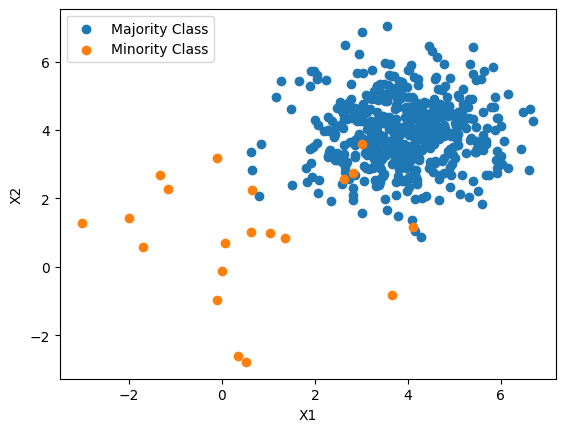

In [2]:
X, y = make_blobs(n_samples = [20, 500], centers = [[1, 1], [4, 4]], cluster_std = [2.0, 1.0], random_state = 14)
data = pd.DataFrame(X, y)
plt.scatter(data.iloc[data.index == 1, 0], data.iloc[data.index == 1, 1], label = "Majority Class", marker = "o")
plt.scatter(data.iloc[data.index == 0, 0], data.iloc[data.index == 0, 1], label = "Minority Class", marker = "o")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

## Section 3: SMOTE Basic Use-case
As previously mentionned, SMOTE is only meaningful when dealing with imbalanced datasets. Furthermore, when used in a Machine Learning Algorithm context, SMOTE must **only** be used on the training set, and not the test set.

First, you can verify that an imbalance is present in your dataset:

In [3]:
print(Counter(data.index))

Counter({1: 500, 0: 20})


Once this is done and imbalance is confirmed, a SMOTE object can be created and then applied to the dataset. The SMOTE object contains a few different attributes with the most important one being the amount of neighbours used.

In [4]:
smote = SMOTE(k_neighbors = 5)
X = data
y = data.index
X_smote, y_smote = smote.fit_resample(X, y)

# Check that SMOTE worked:
print("Original distribution of variables:", Counter(data.index), "\nSMOTE distribution of variables:", Counter(y_smote))

Original distribution of variables: Counter({1: 500, 0: 20}) 
SMOTE distribution of variables: Counter({1: 500, 0: 500})


Here is a visual representation of SMOTE's usage. In this example an arbitrarily-selected decision boundary is plotted to showcase the potential impact of using SMOTE prior to a machine learning algorithm.

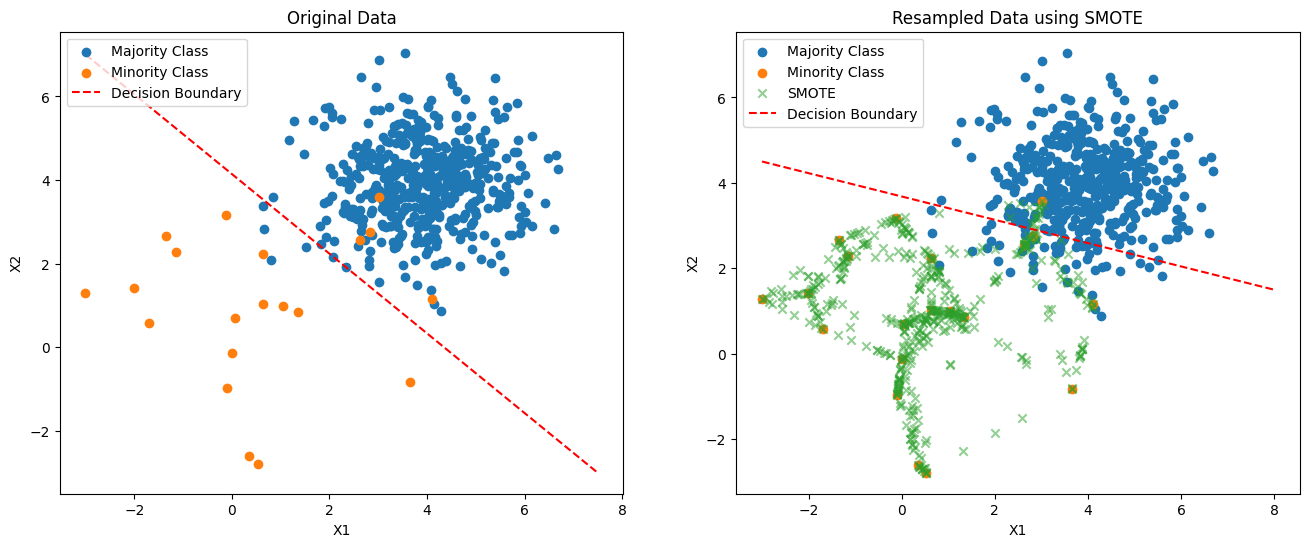

In [5]:
# look at distribution to check for imbalance
plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
plt.scatter(data.iloc[data.index == 1, 0], data.iloc[data.index == 1, 1], label = "Majority Class", marker = "o")
plt.scatter(data.iloc[data.index == 0, 0], data.iloc[data.index == 0, 1], label = "Minority Class", marker = "o")
plt.plot([-3, 7.5], [7, -3], linestyle='--', color='red', label = "Decision Boundary")
plt.title("Original Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc = "upper left")

plt.subplot(1,2,2)
plt.scatter(X_smote.iloc[y_smote == 1, 0], X_smote.iloc[y_smote == 1, 1], label = "Majority Class", marker = "o")
plt.scatter(data.iloc[data.index == 0, 0], data.iloc[data.index == 0, 1], label = "Minority Class", marker = "o", alpha = 1)
plt.scatter(X_smote.iloc[y_smote == 0, 0], X_smote.iloc[y_smote == 0, 1], label = "SMOTE", marker = "x", alpha = 0.5)
plt.plot([-3, 8], [4.5, 1.5], linestyle='--', color='red', label = "Decision Boundary")
plt.title("Resampled Data using SMOTE")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc = "upper left")
plt.show()

An interactive version of SMOTE can be found here: [`ml-tutorials/data_augmentation_smote_slider`](https://github.com/petraknovak/ml-tutorials/blob/main/data_augmentation_smote_slider.py).

The demo shows the impact of varying K values on the generated data points. Feel free to play around with it to see what happens!

## Section 4: Show-case - Diabetes detection

To demonstrate the impact of SMOTE on real-world data, its performance is benchmarked against the raw dataset, its randomly undersampled, and oversampled versions.

KNN with K=5 is used in every case to ensure a robust comparison. This model was picked for its speed of execution and explainability.

The models are run on a dataset for diabetes detection on Indian female individuals (downloadable [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv)).

The dataset consists of 768 records over the following 9 features:
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [6]:
df = pd.read_csv('pima-indians-diabetes.csv', header=None)
df.columns = ['pregnancies', 'glucose', 'pressure', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'response']
df.head()

,pregnancies,glucose,pressure,skin,insulin,bmi,pedigree,age,response
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The distribution of people with and without diabetes is plotted below to outline the class impalance in this dataset.

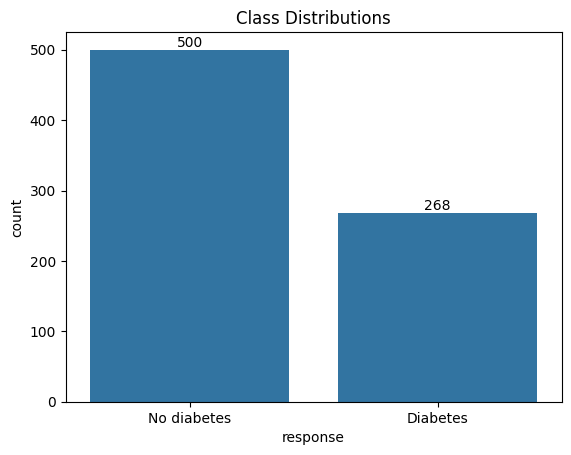

In [7]:
labels = ['No diabetes', 'Diabetes']

ax = sns.countplot(data = df, x = 'response')

# Adding value for each bar
for p, label in zip(ax.patches, labels):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10, f'{height:.0f}', ha = "center", va = "center", fontsize = 10, color = 'black')

ax.set_xticks([0, 1])
ax.set_xticklabels(labels)

plt.title('Class Distributions')
plt.show()

The dataset is split into training and testing sets.

In [8]:
X = df.drop('response', axis = 1).copy()
y = df['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Base KNN model

A first KNN model is run here to be used as benchmark for the augmentation techniques used thereafter.

In [9]:
# Create a pipeline that normalises the data between 0 and 1 before applying KNN
piperand = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
piperand.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

Once the model is trained, we evaluate its performance on the testing set.

In [10]:
y_pred = piperand.predict(X_test)
print(classification_report(y_test, y_pred, target_names = labels))

              precision    recall  f1-score   support

 No diabetes       0.75      0.79      0.77       151
    Diabetes       0.56      0.51      0.54        80

    accuracy                           0.69       231
   macro avg       0.66      0.65      0.65       231
weighted avg       0.69      0.69      0.69       231



Due to the class imbalance, the diabetes cases are hardly detected. Looking at the overall f1 score, the model seems to be doing a decent job. However in this disease detection case, the focus should be shifted towards the recall of the illness (only 51% in this case). Indeed, misclassifying someone as healthy has a higher cost of error than the other way around.

### KNN with undersampling

The same procedure is applied using random undersampling as a pre-processing method.

In [11]:
# Creating an instance of the random undersampler and fitting it to the training set
under_sample = RandomUnderSampler(random_state = 42)
X_under, y_under = under_sample.fit_resample(X_train, y_train)

In [12]:
# Pipeline creation
piperand = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

# Running the pipeline over the undersampled training set
piperand.fit(X_under, y_under)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [13]:
y_under_pred = piperand.predict(X_test)
print(classification_report(y_test, y_under_pred, target_names=labels))

              precision    recall  f1-score   support

 No diabetes       0.80      0.67      0.73       151
    Diabetes       0.52      0.68      0.59        80

    accuracy                           0.67       231
   macro avg       0.66      0.67      0.66       231
weighted avg       0.70      0.67      0.68       231



Even if the overall f1 score slightly diminishes, there is a clear improvement on the diabetes recall side.

### KNN with oversampling

The same logic is applied for oversampling.

In [14]:
over_sample = RandomOverSampler(random_state = 42)
X_over, y_over = over_sample.fit_resample(X_train, y_train)

In [15]:
piperand = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
piperand.fit(X_over, y_over)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [16]:
y_over_pred = piperand.predict(X_test)
print(classification_report(y_test, y_over_pred, target_names=labels))

              precision    recall  f1-score   support

 No diabetes       0.80      0.71      0.75       151
    Diabetes       0.55      0.68      0.61        80

    accuracy                           0.70       231
   macro avg       0.68      0.69      0.68       231
weighted avg       0.72      0.70      0.70       231



There is an overall improvement in comparison with the previous cases.

### KNN with SMOTE

Finally, SMOTE.

In [17]:
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [18]:
piperand = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
piperand.fit(X_smote, y_smote)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [19]:
y_smote_pred = piperand.predict(X_test)
print(classification_report(y_test, y_smote_pred, target_names=labels))

              precision    recall  f1-score   support

 No diabetes       0.83      0.70      0.76       151
    Diabetes       0.56      0.72      0.63        80

    accuracy                           0.71       231
   macro avg       0.69      0.71      0.69       231
weighted avg       0.73      0.71      0.71       231



In this example, SMOTE outperforms its counterparts.

## Section 5: Results and Analysis

We now compute the confusion matrices of the four methods.

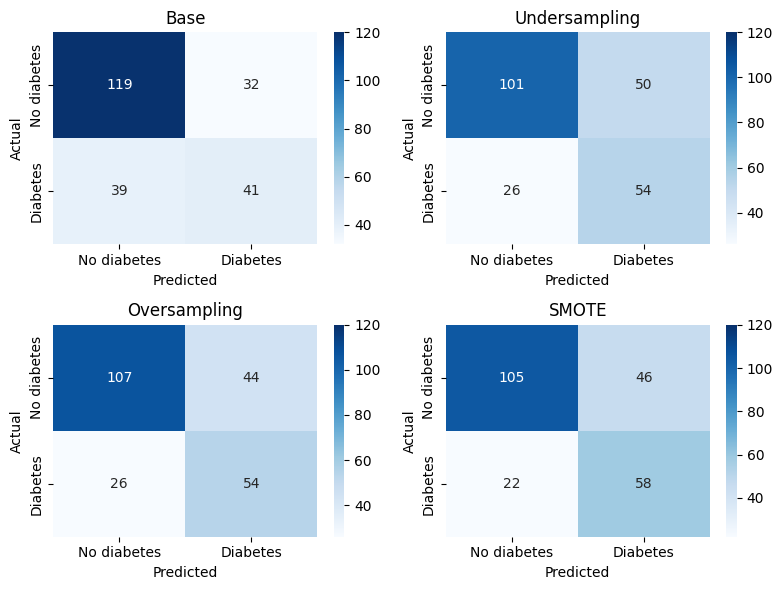

In [20]:
# Compute confusion matrices
cm = confusion_matrix(y_test, y_pred)
cm_under = confusion_matrix(y_test, y_under_pred)
cm_over = confusion_matrix(y_test, y_over_pred)
cm_smote = confusion_matrix(y_test, y_smote_pred)

# Plot them
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(cm, ax=axes[0, 0], annot=True, cmap=plt.cm.Blues, xticklabels = labels, yticklabels = labels, fmt = "d", vmax = 120)
axes[0, 0].set_title("Base")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

sns.heatmap(cm_under, ax=axes[0, 1], annot=True, cmap = plt.cm.Blues, xticklabels = labels, yticklabels = labels, fmt = "d", vmax = 120)
axes[0, 1].set_title("Undersampling")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

sns.heatmap(cm_over, ax=axes[1, 0], annot=True, cmap = plt.cm.Blues, xticklabels = labels, yticklabels = labels, fmt = "d", vmax = 120)
axes[1, 0].set_title("Oversampling")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

sns.heatmap(cm_smote, ax=axes[1, 1], annot=True, cmap = plt.cm.Blues, xticklabels = labels, yticklabels = labels, fmt = "d", vmax = 120)
axes[1, 1].set_title("SMOTE")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

fig.tight_layout()
plt.show()

According to the previously computed metrics and confusion matrices, there is a gradual improvement of modelling techniques from a base model without data balancing to more advanced augmentation techniques.

Main findings:
- Class imbalance leads to poor performances on the minority class.
- Even the most basic balancing methods lead to significant improvements.
- In this specific case, SMOTE outperforms other methods by correctly classifying diabetes cases and minimising errors; particularly, the number of false negatives.
- Note that results are case dependent and should be interpreted in the right context.

## Section 6: Caution

A few words of caution: While balancing methods have proven to be effective in some contexts, they come with challenges and limitations that can hinder their performance.

<u>Random undersampling</u>
- By design, undersampling deletes information. Naturally, model performance can be hindered by the absence of those data points.

<u>Random oversampling</u>
- Due to the duplication of observations, there is an increased risk of overfitting. Too much emphasis can be put on irrelevant pieces of information, or even outliers.

<u>SMOTE</u>
- Data complexity: In case of complex non-linear decision boundary between classes, SMOTE's intervention might give the illusion of a simpler boundary when it is in fact overfitting. This issue can arise in highly-dimensional datasets.
- Data Quality: If the minority class has sparse observations, SMOTE tends to create linear patterns of data points that might not be representative of real data. SMOTE distorts the data distribution of the minority class, making it prone to overfitting.

An example of a poor use case of SMOTE where the algorithm creates patterns of points that ignore large portions of the input space can be found below.

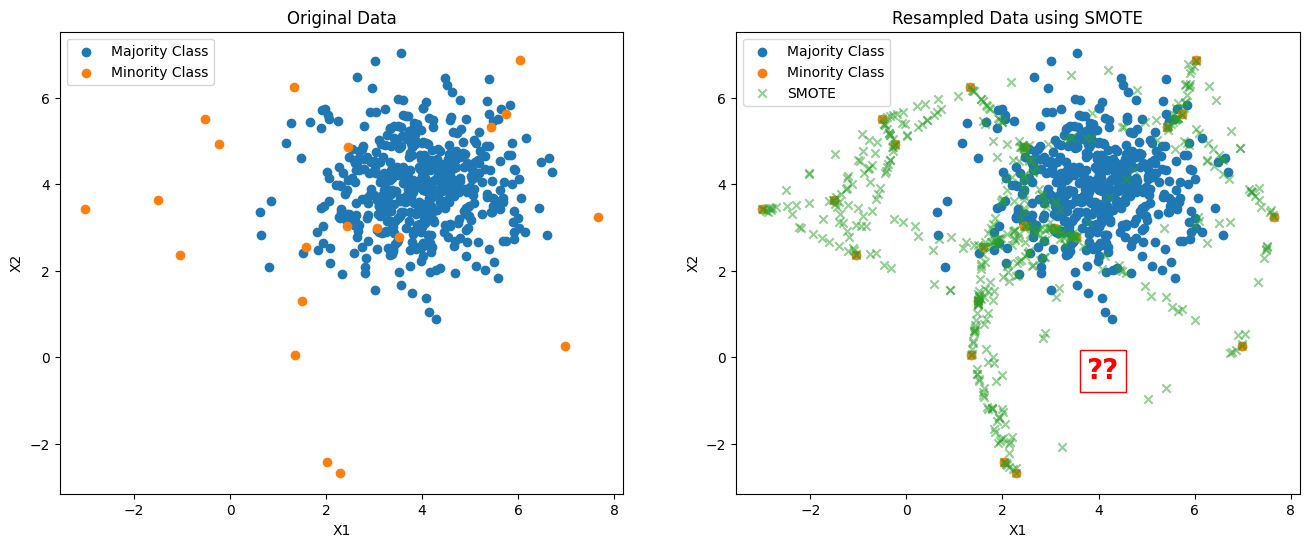

In [21]:
X, y = make_blobs(n_samples = [20, 500], centers = [[3, 3], [4, 4]], cluster_std = [3.0, 1.0], random_state = 14)
data = pd.DataFrame(X, y)
smote = SMOTE(k_neighbors = 5)
X = data
y = data.index
X_smote, y_smote = smote.fit_resample(X, y)

plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
plt.scatter(data.iloc[data.index == 1, 0], data.iloc[data.index == 1, 1], label = "Majority Class", marker = "o")
plt.scatter(data.iloc[data.index == 0, 0], data.iloc[data.index == 0, 1], label = "Minority Class", marker = "o")
plt.title("Original Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc = "upper left")

plt.subplot(1,2,2)
plt.scatter(X_smote.iloc[y_smote == 1, 0], X_smote.iloc[y_smote == 1, 1], label = "Majority Class", marker = "o")
plt.scatter(data.iloc[data.index == 0, 0], data.iloc[data.index == 0, 1], label = "Minority Class", marker = "o", alpha = 1)
plt.scatter(X_smote.iloc[y_smote == 0, 0], X_smote.iloc[y_smote == 0, 1], label = "SMOTE", marker = "x", alpha = 0.5)
plt.text(3.75, -0.5, '??', fontsize=20, weight='bold', color='red', bbox=dict(facecolor='none', edgecolor='red', pad=5.0))
plt.title("Resampled Data using SMOTE")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc = "upper left")
plt.show()

One last thing...
<div class="alert alert-block alert-danger">
<b>Danger:</b> SMOTE must only be applied to the training set to avoid data leakage. Introducing synthetic samples from the minority class into the validation or test sets could result in an overestimation of model performance.
</div>

## Section 7: Summary

- Issues due to data imbalance can be addressed with balancing methods, such as random undersampling, random oversampling, and SMOTE.
- Each method has pros and cons that should be considered on a case-by-case basis.
- The impact of balancing methods can vary depending on the machine learning algorithm used.
- Such methods do not work in every scenario. If the minority class is very heterogeneous, it is unlikely that the methods introduced here will solve the issue. Remember, "garbage in, garbage out!"
- Lastly, to improve performance undersampling and oversampling methods can be used sequentially.

# Section 8: References and Resources
**Pima Indians Diabetes dataset**
- Dataset description: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names
- Dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv

**References**
- `Imbalanced learn` package installation: https://imbalanced-learn.org/stable/install.html
- Video explanation:
    - Chapter 21.08: Sampling Methods 1: https://slds-lmu.github.io/i2ml/chapters/21_imbalanced_learning/21-08-smpl-1/
    - Chapter 21.09: Sampling Methods 2: https://slds-lmu.github.io/i2ml/chapters/21_imbalanced_learning/21-09-smpl-2/
- Code tutorials:
    - Create Artificial Data With SMOTE: https://towardsdatascience.com/create-artificial-data-with-smote-2a31ee855904
    - SMOTE for Imbalanced Classification with Python: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- Other:
    - SMOTE for high-dimensional class-imbalanced data: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106
    - SMOTE: Practical Consideration & Limitations: https://medium.com/@minjukim023/smote-practical-consideration-limitations-f0d926b661a8
    - I Declare Myself the #1 Enemy of Over/Undersampling, SMOTE and ADASYN, Here’s Why & How I Circumvent It: https://juandelacalle.medium.com/i-declare-myself-the-1-enemy-of-over-undersampling-smote-and-adasyn-heres-why-how-i-5889b5073419
    - ChatGPT was used for debugging and visualisation purposes
    - Author contributions: assignment done together from start to finish

## Section 9: Review Questions

- What is data imbalance?
- List 3 methods that can be used to deal with data imbalance. What is their intuition?
- What are their pros and cons?
- What is the impact of changing the number of neighbors K considered in SMOTE?
- Should SMOTE be used on the whole dataset or only the training set? Why?
- If you have time, try changing the number of neighbors K and combining different techniques. Are there notable performance differences?